In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [2]:
file = ROOT.TFile.Open("4h_copy_ratio_FR.root")
#direc = file.Get("QFillByFillAnalyzerDB")
hist = ROOT.TH1D()
hist = file.Get("calo_histogram_sum_ratio")
hcov = ROOT.TH2D()
hcov = file.Get("hcov")

loss_file = ROOT.TFile.Open("LostMuonsSpectra.root")
direc = loss_file.Get("Run2All")
hlm = ROOT.TH1F()
hlm = direc.Get("triple_losses_spectra_integral")

loss_file_2 = ROOT.TFile.Open("reconEmuonloss.root")
#direc = loss_file.Get("Run3a")
hlm_2 = ROOT.TH1D()
hlm_2 = loss_file_2.Get("lambda2")

In [3]:
hlm.Scale(1.0/hlm.GetBinContent(hlm.GetNbinsX()))
hlm_2.Scale(1.0/hlm_2.GetBinContent(hlm_2.GetNbinsX()))

In [4]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [5]:
fit_start=30000
fit_stop=300000
fit_range=hist.FindBin(fit_stop)-hist.FindBin(fit_start)+1

T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

y_val=np.empty(fit_range)
y_err=np.empty(fit_range)
x_val=np.empty(fit_range)
x_mloss=np.empty(fit_range)
y_mloss=np.empty(fit_range)
x_mloss_2=np.empty(fit_range)
y_mloss_2=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_val[ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
    y_err[ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
    x_val[ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))
    x_mloss[ibin]=hlm.GetBinCenter(ibin+hlm.FindBin(fit_start))
    y_mloss[ibin]=hlm.GetBinContent(ibin+hlm.FindBin(fit_start))
    x_mloss_2[ibin]=hlm_2.GetBinCenter(ibin+hlm_2.FindBin(fit_start))
    y_mloss_2[ibin]=hlm_2.GetBinContent(ibin+hlm_2.FindBin(fit_start))

y_cov = np.empty(shape=(fit_range,fit_range))

for irow in range (0, fit_range):
      for icol in range(0, fit_range):
            y_cov[irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))

In [6]:
y_mlossf=np.empty(fit_range)
y_mlossb=np.empty(fit_range)

y_mlossf_2=np.empty(fit_range)
y_mlossb_2=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_mlossf[ibin]=hlm.GetBinContent(ibin+hlm.FindBin(fit_start)+nbinshift)
    y_mlossb[ibin]=hlm.GetBinContent(ibin+hlm.FindBin(fit_start)-nbinshift) 
    y_mlossf_2[ibin]=hlm_2.GetBinContent(ibin+hlm_2.FindBin(fit_start)+nbinshift)
    y_mlossb_2[ibin]=hlm_2.GetBinContent(ibin+hlm_2.FindBin(fit_start)-nbinshift)

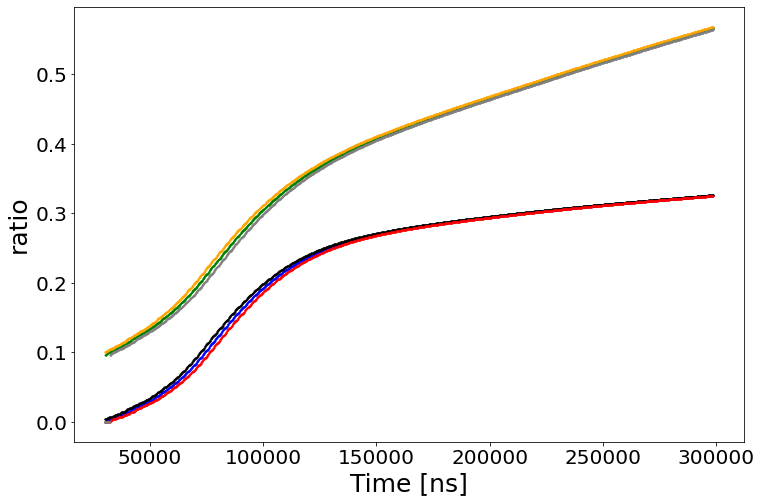

In [7]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
#plt.scatter(x_mloss_2, y_mloss_2, s=0.9, color='red', label='Data')
plt.scatter(x_mloss, y_mloss, s=0.9, color='blue', label='Data')
plt.scatter(x_mloss, y_mlossf, s=0.9, color='black', label='Data')
plt.scatter(x_mloss, y_mlossb, s=0.9, color='red', label='Data')
plt.scatter(x_mloss_2, y_mloss_2, s=0.9, color='green', label='Data')
plt.scatter(x_mloss_2, y_mlossf_2, s=0.9, color='orange', label='Data')
plt.scatter(x_mloss_2, y_mlossb_2, s=0.9, color='gray', label='Data')
#plt.plot(x_val, fit, linestyle='--', linewidth=1, color='red')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('ratio',fontsize=25)
#plt.ylim([0.0, 6000000000])
#plt.xlim([100000,150000])
plt.show()

In [123]:
diff=np.linspace(0,len(x_mloss),len(x_mloss))

In [124]:
freq=np.empty(10)
dfreq=np.empty(10)

In [125]:
def fit_func3(time: np.double,
              asym: np.double = 0.0, 
              R: np.double = 0.0, 
              phi: np.double = 0.0)-> np.double:
    
    
    f=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*time - phi))

    ff=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi))

    fb=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi))

    
    return (2*f - ff - fb)/(2*f + ff + fb)

In [126]:
def fit_func7(time: np.double,
              asym: np.double = 0.0, 
              R: np.double = 0.0, 
              phi: np.double = 0.0,
              asym_cbo = 0.0,
              tau_cbo = 0.0,
              omega_cbo = 0.0,
              phi_cbo = 0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
                
    
    f=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*time - phi))

    ff=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi))

    fb=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi))

    
    return (2*f*Ncbo - ff*Ncbof - fb*Ncbob)/(2*f*Ncbo + ff*Ncbof + fb*Ncbob)

In [127]:
def fit_func11(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
            
    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo - ff*Ncbof - fb*Ncbob)/(2*f*Ncbo + ff*Ncbof + fb*Ncbob)

In [128]:
def fit_func15(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0,
               asym_vw= 0.0,
               tau_vw = 0.0,
               omega_vw = 0.0,
               phi_vw = 0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
        
    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw - ff*Ncbof*Nvwf - fb*Ncbob*Nvwb)/(2*f*Ncbo*Nvw + ff*Ncbof*Nvwf + fb*Ncbob*Nvwb)

In [129]:
def fit_func19(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0,
               asym_vw= 0.0,
               tau_vw = 0.0,
               omega_vw = 0.0,
               phi_vw = 0.0,
               asym_vbo= 0.0,
               tau_vbo = 0.0,
               omega_vbo = 0.0,
               phi_vbo = 0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time + phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time + phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo - ff*Ncbof*Nvwf*Nvbof - fb*Ncbob*Nvwb*Nvbob)/(2*f*Ncbo*Nvw*Nvbo + ff*Ncbof*Nvwf*Nvbof + fb*Ncbob*Nvwb*Nvbob)

In [130]:
def fit_func(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0,
             asym_vw= 0.0,
             tau_vw = 0.0,
             omega_vw = 0.0,
             phi_vw = 0.0,
             asym_vbo= 0.0,
             tau_vbo = 0.0,
             omega_vbo = 0.0,
             phi_vbo = 0.0,
             asym_2cbo= 0.0,
             tau_2cbo = 0.0,
             omega_2cbo = 0.0,
             phi_2cbo = 0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    N2cbo=(asym_2cbo*exp(-time/tau_2cbo)*cos(omega_2cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/tau_2cbo)*cos(omega_2cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/tau_2cbo)*cos(omega_2cbo*(time - T_a/2) - phi_2cbo))
    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo - ff*Ncbof*Nvwf*Nvbof - fb*Ncbob*Nvwb*Nvbob)/(2*f*Ncbo*Nvw*Nvbo + ff*Ncbof*Nvwf*Nvbof + fb*Ncbob*Nvwb*Nvbob)

In [131]:
def fit_func_new(time: np.double,
                 asym: np.double = 0.0, 
                 R: np.double = 0.0, 
                 phi: np.double = 0.0,
                 asym_cbo = 0.0,
                 tau_cbo = 0.0,
                 omega_cbo = 0.0,
                 phi_cbo = 0.0,
                 asym_cbo_A = 0.0,
                 phi_cbo_A=0.0,
                 A_cbo_phi= 0.0,
                 phi_cbo_phi=0.0,
                 asym_vw= 0.0,
                 tau_vw = 0.0,
                 omega_vw = 0.0,
                 phi_vw = 0.0,
                 asym_vbo= 0.0,
                 tau_vbo = 0.0,
                 omega_vbo = 0.0,
                 phi_vbo = 0.0,
                 asym_2cbo= 0.0,
                 tau_2cbo = 0.0,
                 omega_2cbo = 0.0,
                 phi_2cbo = 0.0,
                 A_new = 0.0,
                 phi_new = 0.0)-> np.double:
    
    tau_new=52000
    omega_new=0.01197
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    N2cbo=(asym_2cbo*exp(-time/tau_2cbo)*cos(omega_2cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/tau_2cbo)*cos(omega_2cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/tau_2cbo)*cos(omega_2cbo*(time - T_a/2) - phi_2cbo))
    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob
    
    Nnew=(1+ A_new*exp(-time/tau_new)*cos(omega_new*time - phi_new))
    Nnewf=(1+ A_new*exp(-(time + T_a/2)/tau_new)*cos(omega_new*(time + T_a/2) - phi_new))
    Nnewb=(1+ A_new*exp(-(time - T_a/2)/tau_new)*cos(omega_new*(time - T_a/2) - phi_new))

    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Nnew - ff*Ncbof*Nvwf*Nvbof*Nnewf - fb*Ncbob*Nvwb*Nvbob*Nnewb)/(2*f*Ncbo*Nvw*Nvbo*Nnew + ff*Ncbof*Nvwf*Nvbof*Nnewf + fb*Ncbob*Nvwb*Nvbob*Nnewb)

In [132]:
def fit_func_VD(time: np.double,
                asym: np.double = 0.0, 
                R: np.double = 0.0, 
                phi: np.double = 0.0,
                asym_cbo = 0.0,
                tau_cbo = 0.0,
                omega_cbo = 0.0,
                phi_cbo = 0.0,
                asym_cbo_A = 0.0,
                phi_cbo_A=0.0,
                A_cbo_phi= 0.0,
                phi_cbo_phi=0.0,
                asym_vw= 0.0,
                tau_vw = 0.0,
                omega_vw = 0.0,
                phi_vw = 0.0,
                asym_vbo= 0.0,
                tau_vbo = 0.0,
                omega_vbo = 0.0,
                phi_vbo = 0.0,
                asym_2cbo= 0.0,
                tau_2cbo = 0.0,
                omega_2cbo = 0.0,
                phi_2cbo = 0.0,
                A_new = 0.0,
                phi_new = 0.0,
                A_VD = 0.0)-> np.double:
    
    tau_new=52000
    omega_new=0.01197
    
    tau_VD=55500
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    N2cbo=(asym_2cbo*exp(-time/tau_2cbo)*cos(omega_2cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/tau_2cbo)*cos(omega_2cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/tau_2cbo)*cos(omega_2cbo*(time - T_a/2) - phi_2cbo))
    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob
    
    Nnew=(1+ A_new*exp(-time/tau_new)*cos(omega_new*time - phi_new))
    Nnewf=(1+ A_new*exp(-(time + T_a/2)/tau_new)*cos(omega_new*(time + T_a/2) - phi_new))
    Nnewb=(1+ A_new*exp(-(time - T_a/2)/tau_new)*cos(omega_new*(time - T_a/2) - phi_new))
    
    NVD =  (1 + A_VD * exp (-time/tau_VD));
    NVDf =  (1 + A_VD * exp (-(time + T_a/2)/tau_VD));
    NVDb =  (1 + A_VD * exp (-(time - T_a/2)/tau_VD));

    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Nnew*NVD - ff*Ncbof*Nvwf*Nvbof*Nnewf*NVDf - fb*Ncbob*Nvwb*Nvbob*Nnewb*NVDb)/(2*f*Ncbo*Nvw*Nvbo*Nnew*NVD + ff*Ncbof*Nvwf*Nvbof*Nnewf*NVDf + fb*Ncbob*Nvwb*Nvbob*Nnewb*NVDb)

In [133]:
#def closest_idx(t):
    #for ibin in range (0,fit_range):
        #diff[ibin]=np.abs(x_mloss[ibin]-t)
    #min_idx=np.argmin(diff)
    #return min_idx

In [134]:
def fit_func_lm(time: np.double,
                asym: np.double = 0.0, 
                R: np.double = 0.0, 
                phi: np.double = 0.0,
                asym_cbo = 0.0,
                tau_cbo = 0.0,
                omega_cbo = 0.0,
                phi_cbo = 0.0,
                asym_cbo_A = 0.0,
                phi_cbo_A=0.0,
                A_cbo_phi= 0.0,
                phi_cbo_phi=0.0,
                asym_vw= 0.0,
                tau_vw = 0.0,
                omega_vw = 0.0,
                phi_vw = 0.0,
                asym_vbo= 0.0,
                tau_vbo = 0.0,
                omega_vbo = 0.0,
                phi_vbo = 0.0,
                asym_2cbo= 0.0,
                tau_2cbo = 0.0,
                omega_2cbo = 0.0,
                phi_2cbo = 0.0,
                A_new = 0.0,
                phi_new = 0.0,
                A_VD = 0.0,
                A_lm = 0.0)-> np.double:
    
    tau_new=52000
    omega_new=0.01197
    
    tau_VD=55500
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    N2cbo=(asym_2cbo*exp(-time/tau_2cbo)*cos(omega_2cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/tau_2cbo)*cos(omega_2cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/tau_2cbo)*cos(omega_2cbo*(time - T_a/2) - phi_2cbo))
    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob
    
    Nnew=(1+ A_new*exp(-time/tau_new)*cos(omega_new*time - phi_new))
    Nnewf=(1+ A_new*exp(-(time + T_a/2)/tau_new)*cos(omega_new*(time + T_a/2) - phi_new))
    Nnewb=(1+ A_new*exp(-(time - T_a/2)/tau_new)*cos(omega_new*(time - T_a/2) - phi_new))
    
    NVD =  (1 + A_VD * exp (-time/tau_VD))
    NVDf =  (1 + A_VD * exp (-(time + T_a/2)/tau_VD))
    NVDb =  (1 + A_VD * exp (-(time - T_a/2)/tau_VD))
    
    #for ibin in range (0,fit_range):
        #diff[ibin]=np.abs(x_mloss[ibin]-time)
    #min_idx=np.argmin(diff)
    
    #for ibin in range (0,fit_range):
        #diff[ibin]=np.abs(x_mloss[ibin]-(time + T_a/2))
    #min_idxf=np.argmin(diff)

    #for ibin in range (0,fit_range):
        #diff[ibin]=np.abs(x_mloss[ibin]-(time - T_a/2))
    #min_idxb=np.argmin(diff)


    
    Nloss = (1 - A_lm * y_mloss)
    Nlossf = (1 - A_lm * y_mlossf) 
    Nlossb = (1 - A_lm * y_mlossb) 
    
    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Nnew*NVD*Nloss - ff*Ncbof*Nvwf*Nvbof*Nnewf*NVDf*Nlossf - fb*Ncbob*Nvwb*Nvbob*Nnewb*NVDb*Nlossb)/(2*f*Ncbo*Nvw*Nvbo*Nnew*NVD*Nloss + ff*Ncbof*Nvwf*Nvbof*Nnewf*NVDf*Nlossf + fb*Ncbob*Nvwb*Nvbob*Nnewb*NVDb*Nlossb)

In [135]:
p_init_3=[0.228,0.00,4.01]

In [136]:
pars3, cov3= opt.curve_fit(f=fit_func3, xdata=x_val, ydata=y_val, p0=p_init_3, sigma=y_cov)

In [137]:
stdevs3 = np.sqrt(np.diag(cov3))
freq[0]=pars3[1]
dfreq[0]=stdevs3[1]

In [138]:
p_init_7=pars3
p_init_7=np.append(pars3,[0.0024,254000,0.00234,5.7])

In [139]:
p_init_7

array([ 2.28866767e-01, -4.43069915e+01,  4.01446850e+00,  2.40000000e-03,
        2.54000000e+05,  2.34000000e-03,  5.70000000e+00])

In [140]:
pars7, cov7= opt.curve_fit(f=fit_func7, xdata=x_val, ydata=y_val, p0=p_init_7, sigma=y_cov)

In [141]:
stdevs7 = np.sqrt(np.diag(cov7))
freq[1]=pars7[1]
dfreq[1]=stdevs7[1]

In [142]:
p_init_11=pars7
p_init_11=np.append(p_init_11,[0.0006,0.5,0.00006,2.78])

In [143]:
pars11, cov11= opt.curve_fit(f=fit_func11, xdata=x_val, ydata=y_val, p0=p_init_11, sigma=y_cov)

In [144]:
stdevs11 = np.sqrt(np.diag(cov11))
freq[2]=pars11[1]
dfreq[2]=stdevs11[1]

In [145]:
p_init_15=pars11
p_init_15=np.append(p_init_15,[0.0002,138000,0.01393,6.01])

In [146]:
pars15, cov15= opt.curve_fit(f=fit_func15, xdata=x_val, ydata=y_val, p0=p_init_15, sigma=y_cov)

In [147]:
stdevs15 = np.sqrt(np.diag(cov15))
freq[3]=pars15[1]
dfreq[3]=stdevs15[1]

In [148]:
p_init_19=pars15
p_init_19=np.append(p_init_19,[0.001,34000,0.01404,0.63])

In [149]:
pars19, cov19= opt.curve_fit(f=fit_func19, xdata=x_val, ydata=y_val, p0=p_init_19, sigma=y_cov)

In [150]:
stdevs19 = np.sqrt(np.diag(cov19))
freq[4]=pars19[1]
dfreq[4]=stdevs19[1]

In [151]:
p_init=pars19
p_init=np.append(p_init,[1.10668e-04,1.70775e+05,4.69116e-03,3.06805e+00])

In [152]:
pars2, cov2 = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_cov)

In [153]:
stdevs2 = np.sqrt(np.diag(cov2))
freq[5]=pars2[1]
dfreq[5]=stdevs2[1]

In [154]:
p_init_new=pars2
p_init_new=np.append(p_init_new,[0.0001,2.5])

In [155]:
pars_new, cov_new = opt.curve_fit(f=fit_func_new, xdata=x_val, ydata=y_val, p0=p_init_new, sigma=y_cov)

In [156]:
stdevs_new = np.sqrt(np.diag(cov_new))
freq[6]=pars_new[1]
dfreq[6]=stdevs_new[1]

In [157]:
p_init_VD=pars_new
p_init_VD=np.append(p_init_VD,[0.001])

In [158]:
pars_VD, cov_VD = opt.curve_fit(f=fit_func_VD, xdata=x_val, ydata=y_val, p0=p_init_VD, sigma=y_cov)

In [159]:
stdevs_VD = np.sqrt(np.diag(cov_VD))
freq[7]=pars_VD[1]
dfreq[7]=stdevs_VD[1]

In [160]:
p_init_lm=pars_new
p_init_lm=np.append(p_init_lm,[0.0])

In [161]:
pars_lm, cov_lm = opt.curve_fit(f=fit_func_lm, xdata=x_val, ydata=y_val, p0=p_init_lm, sigma=y_cov)

In [162]:
stdevs_lm = np.sqrt(np.diag(cov_lm))
freq[8]=pars_lm[1]
dfreq[8]=stdevs_lm[1]

In [163]:
pars_lm

array([ 2.28839865e-01, -4.45450762e+01,  4.01441931e+00,  2.41406029e-03,
        2.56268583e+05,  2.34054628e-03,  5.71972871e+00,  6.95541259e-04,
       -5.53600899e-01, -6.99250122e-05,  2.81232015e+00,  2.10203773e-04,
        1.58134066e+05,  1.39301370e-02,  5.90238742e+00,  1.38595574e-03,
        2.85655306e+04,  1.40381352e-02, -1.95518982e+00,  1.20153188e-04,
        1.44499447e+05,  4.68966927e-03,  3.09702699e+00,  3.04817969e-03,
        1.62610845e+01, -1.62962812e-04])

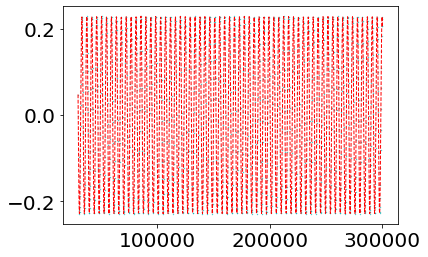

In [164]:
# Plot the noisy exponential data
plt.scatter(x_val, y_val, s=0.1, color='#00b3b3', label='Data')
plt.plot(x_val, fit_func_lm(x_val, *pars_lm), linestyle='--', linewidth=1, color='red')
#plt.ylim([0.0, 6000000000])
#plt.xlim([100000,150000])
plt.show()

In [165]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov_lm))
# Calculate the residuals
res = (y_val - fit_func_lm(x_val, *pars_lm))/y_err

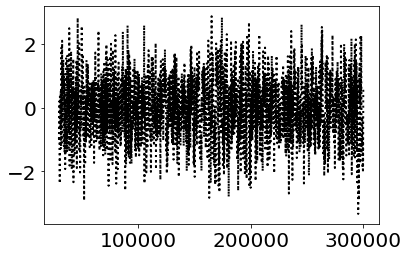

In [166]:
# Plot the noisy exponential data
plt.plot(x_val, res, linestyle='dotted', linewidth=2, color='black')
#plt.xlim([100000,150000])

In [167]:
stdevs

array([8.94055252e-06, 4.97348701e-01, 7.56190579e-05, 2.52054262e-05,
       8.25587178e+03, 1.25895772e-07, 1.04651763e-02, 7.58693788e-05,
       1.08173219e-01, 7.59872103e-05, 1.10228294e+00, 3.34692755e-05,
       4.74018308e+04, 1.89887656e-06, 1.59684683e-01, 2.10721873e-04,
       2.77317463e+03, 3.39679808e-06, 1.52108789e-01, 3.15985839e-05,
       7.68184857e+04, 3.67119902e-06, 2.61950833e-01, 2.86209172e-03,
       9.38459517e-01, 2.82428859e-03])

In [168]:
fou=abs(np.fft.fft(res))

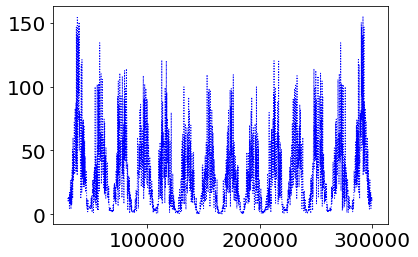

In [169]:
plt.plot(x_val, fou, linestyle='dotted', linewidth=1, color='blue')

In [170]:
chi2=np.dot((np.transpose(y_val-fit_func_lm(x_val, *pars_lm))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func_lm(x_val, *pars_lm)))))

In [171]:
chi2

1680.1296373088164

In [172]:
ndf=fit_range-len(pars_lm)

In [173]:
red_chi2=chi2/ndf

In [174]:
red_chi2

0.9465519083429952

In [175]:
pars2

array([ 2.28839832e-01, -4.45412656e+01,  4.01442009e+00,  2.41429664e-03,
        2.56215157e+05,  2.34054621e-03,  5.71972047e+00,  6.95383094e-04,
       -5.53382503e-01, -7.08798301e-05,  2.82231023e+00,  2.10276854e-04,
        1.57997783e+05,  1.39300801e-02,  5.89632963e+00,  1.39096499e-03,
        2.84991200e+04,  1.40382338e-02, -1.94938112e+00,  1.20167467e-04,
        1.44412314e+05,  4.68964730e-03,  3.09471745e+00])

In [176]:
freq

array([-44.30699147, -44.32121273, -44.43418617, -44.52290114,
       -44.49427752, -44.54126556, -44.54408064, -44.54500292,
       -44.54507624,   0.2       ])

In [177]:
dfreq

array([2.33296605, 0.69144908, 0.68456095, 0.5332103 , 0.50503464,
       0.49675723, 0.49691706, 0.49723798, 0.4973487 , 0.        ])

In [77]:
pars2

array([ 2.28839835e-01, -4.45413571e+01,  4.01442008e+00,  2.41430346e-03,
        2.56211558e+05,  2.34054617e-03,  5.71971712e+00,  6.95362408e-04,
       -5.53382699e-01, -6.94398884e-05,  2.82014933e+00,  2.10309288e-04,
        1.57958584e+05,  1.39300796e-02,  5.89626967e+00, -1.39104791e-03,
        2.84976961e+04,  1.40382363e-02,  1.19233527e+00,  1.20158793e-04,
        1.44435676e+05,  4.68963920e-03,  3.09422838e+00])